In [8]:
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import numpy as np
from torch import nn, argmax
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from sklearn.decomposition import PCA
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import sys
import argparse
import matplotlib.pyplot as plt

In [5]:
device = 0

# get X_test, X_train, and y_train np arrays
data = loadmat('data.mat')
X_test = data['X_test']
X_train = data['X_train']
y_train = data['y_train']
y_train = y_train.transpose()

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

y_train = y_train.reshape(-1)
X_train, X_test = scaleData(X_train, X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [4]:
def scaleData(x_tr, x_test):
    scaler = StandardScaler()
    scaler.fit(x_tr)
    x_tr = scaler.transform(x_tr)
    x_test = scaler.transform(x_test)
    
    return x_tr, x_test


In [12]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                    optimizer_params=dict(lr=.02),
                    scheduler_params={"step_size":20, # how to use learning rate scheduler
                                        "gamma":0.9},
                    scheduler_fn=torch.optim.lr_scheduler.StepLR,
                    mask_type='entmax' # "sparsemax"
                    )

# fit the model 
clf.fit(
    X_train,y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'val'],
    eval_metric=['accuracy', 'balanced_accuracy'],
    max_epochs=200 , patience=20,
    batch_size=8192, virtual_batch_size=256,
    num_workers=0,
    weights=1,
    drop_last=False
)

save_path = clf.save_model('TabNet')

val_preds = clf.predict(X_val)
train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

val_acc = balanced_accuracy_score(y_val, val_preds)
train_acc = balanced_accuracy_score(y_train, train_preds)

print("Final Balanced Val Accuracy: {}".format(val_acc), flush=True)
print("Final Balanced Train Accuracy: {}".format(train_acc), flush=True)


Device used : cuda
epoch 0  | loss: 1.09455 | train_accuracy: 0.43219 | train_balanced_accuracy: 0.50555 | val_accuracy: 0.43232 | val_balanced_accuracy: 0.50329 |  0:00:11s
epoch 1  | loss: 0.94968 | train_accuracy: 0.48924 | train_balanced_accuracy: 0.55266 | val_accuracy: 0.49058 | val_balanced_accuracy: 0.54971 |  0:00:22s
epoch 2  | loss: 0.90488 | train_accuracy: 0.53699 | train_balanced_accuracy: 0.58003 | val_accuracy: 0.53905 | val_balanced_accuracy: 0.57735 |  0:00:33s
epoch 3  | loss: 0.87237 | train_accuracy: 0.56198 | train_balanced_accuracy: 0.59997 | val_accuracy: 0.56088 | val_balanced_accuracy: 0.59625 |  0:00:45s
epoch 4  | loss: 0.85162 | train_accuracy: 0.59613 | train_balanced_accuracy: 0.61501 | val_accuracy: 0.59483 | val_balanced_accuracy: 0.60968 |  0:00:56s
epoch 5  | loss: 0.83353 | train_accuracy: 0.60618 | train_balanced_accuracy: 0.62445 | val_accuracy: 0.60447 | val_balanced_accuracy: 0.61958 |  0:01:08s
epoch 6  | loss: 0.82159 | train_accuracy: 0.60601 

Text(0.5, 1.0, 'Train vs. Validation Balanced Accuracy over 70 Epochs')

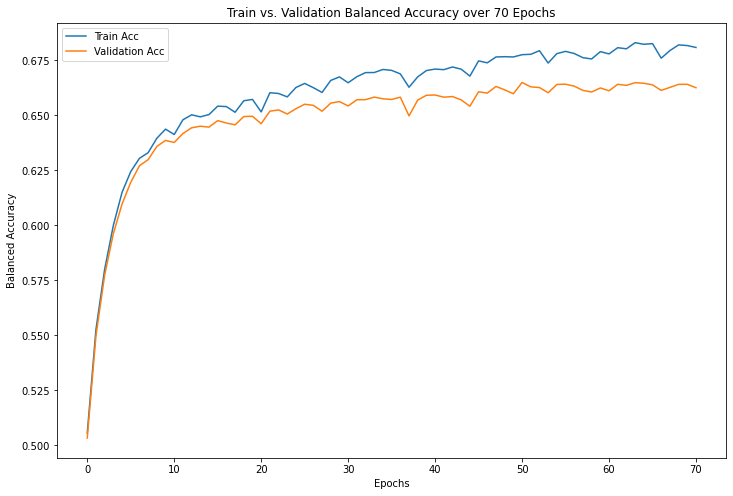

In [22]:
epochs = [x for x in range(71)]
plt.figure(figsize= (12,8))
plt.plot(epochs, clf.history['train_balanced_accuracy'], label = "Train Acc")
plt.plot(epochs, clf.history['val_balanced_accuracy'], label = "Validation Acc")
plt.xlabel('Epochs')
plt.ylabel('Balanced Accuracy')
plt.legend()
plt.title("Train vs. Validation Balanced Accuracy over 70 Epochs")

Text(0.5, 1.0, 'Cross-Entropy Loss')

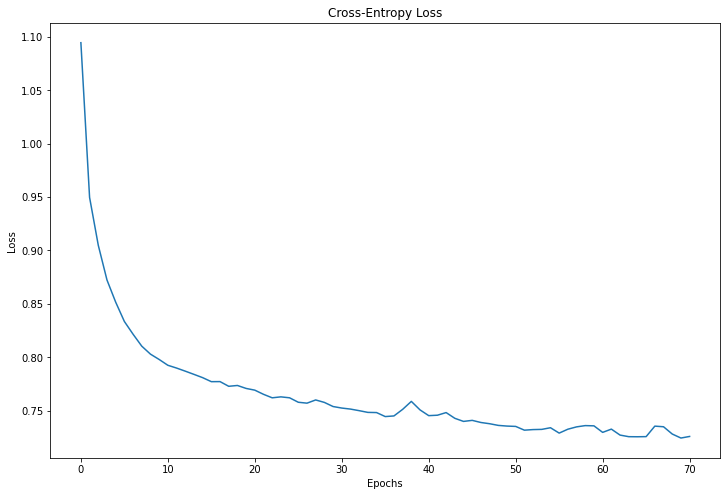

In [24]:

plt.figure(figsize= (12,8))
plt.plot(epochs, clf.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Cross-Entropy Loss")